In [ ]:
#!pip install feature_selector

# специальный класс для отбора информативных признаков
#from feature_selector import FeatureSelector

1. Clonesize [Square Meter] : размер клонов черники может повлиять на общий урожай, поскольку более крупные клоны могут давать больше плодов. Однако зависимость может быть нелинейной, так как на урожай плодов могут влиять и другие факторы.

2. Honeybee, Bumbles bee, Andrena bee, Osmia bee [Square meter/mins] : плотность различных видов пчел имеет решающее значение для эффективности опыления, что напрямую влияет на завязывание плодов и урожайность. Различные виды пчел могут иметь разную степень эффективности опыления дикой черники.

3. MaxOfUpperTRange, MinOfUpperTRange, AverageOfUpperTRange, MaxOfLowerTRange, MinOfLowerTRange, AverageOfLowerTRange [Celcius] : диапазоны температур могут существенно влиять на рост растений и активность опылителей. Экстремальные температуры могут вызывать стресс у растений или ограничить активность опылителей, что может негативно сказаться на урожайности.

4. RainingDays, AverageRainingDays [Days] : Дождливые дни могут по-разному влиять на урожайность. С одной стороны, достаточное количество воды необходимо для роста растений. С другой стороны, чрезмерный дождь или дождь во время сезона цветения может снизить активность опылителей и повлиять на завязывание плодов.

5. Fruitset[proportion]: Завязь плодов относится к пропорции цветков, которые превращаются в плоды. Это критический фактор в определении урожайности, так как более высокая завязываемость плодов обычно приводит к более высокому урожаю.

6. Fruitmass [grams] : масса отдельных плодов также является важным фактором, так как более крупные плоды вносят больший вклад в общий урожай. На изменчивость массы плодов могут влиять такие факторы, как эффективность опыления, доступность ресурсов и условия окружающей среды.

7. Seeds [unit] : Количество семян в плоде может иметь вторичное влияние на урожайность. Хотя это и не является прямым фактором, определяющим урожайность, большее количество семян может указывать на лучшее опыление, что может способствовать более высокому завязыванию плодов и урожаю.


In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from scipy.cluster.hierarchy import linkage, dendrogram
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import RFE
from optuna.samplers import TPESampler
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn. metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score, mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
data = train.copy()
test = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')
submit = pd.read_csv('/kaggle/input/playground-series-s3e14/sample_submission.csv')
train.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


## EDA

In [3]:
data.describe()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,15288.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


In [4]:
# Удалим столбец id
train = train.iloc[:,1:]
data = data.iloc[:,1:]

In [5]:
# Удалим дубликаты
data = data.drop_duplicates()

In [6]:
# Посмотрим на наличие пустых значений
data.isnull().values.any()

False

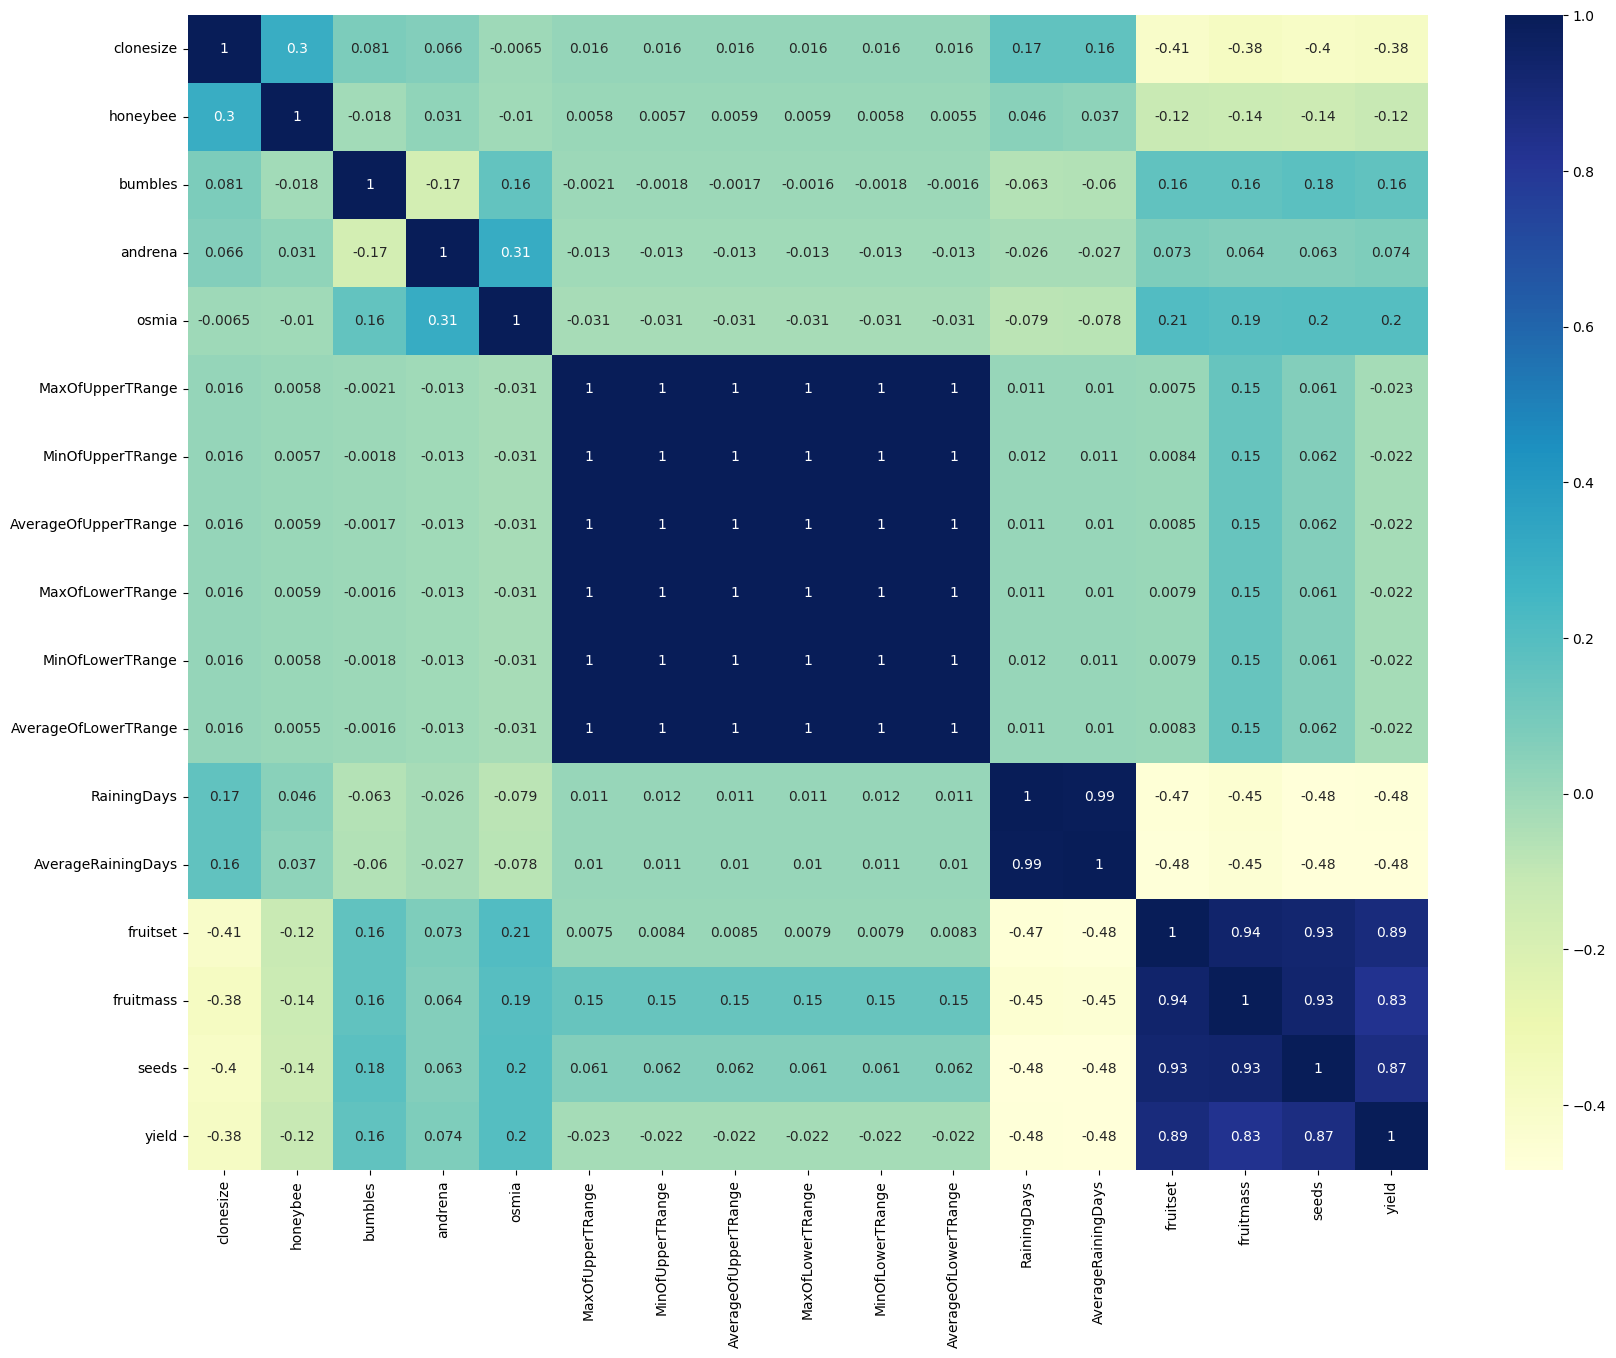

In [8]:
#Correlation using heatmap

plt.figure(figsize = (20, 15))
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

##  FEATURE ENGINEERING

In [10]:
# Assuming 'data' is your DataFrame
correlation_matrix = data.corr()

# Установим порог корреляции
correlation_threshold = 0.1

# Корреляция с целевой переменной (yield)
target_correlations = correlation_matrix['yield']

# Отфильтруем признаки, которые у которых корреляция выше порога
important_features = target_correlations[abs(target_correlations) >= correlation_threshold].index.tolist()

# Выведем важные признаки
print("Important features based on the Correlation threshold with the fruit yield column:", important_features)

# Создадим новый DataFrame с важными признаками
important_data = data[important_features]

Important features based on the Correlation threshold with the fruit yield column: ['clonesize', 'honeybee', 'bumbles', 'osmia', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']


### Сгруппируем значения некоторых признаков 

<AxesSubplot: xlabel='clonesize', ylabel='yield'>

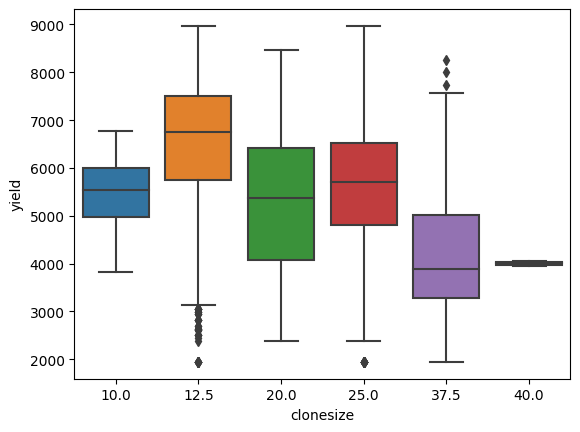

In [12]:
sns.boxplot(data = data, x = 'clonesize', y = 'yield')

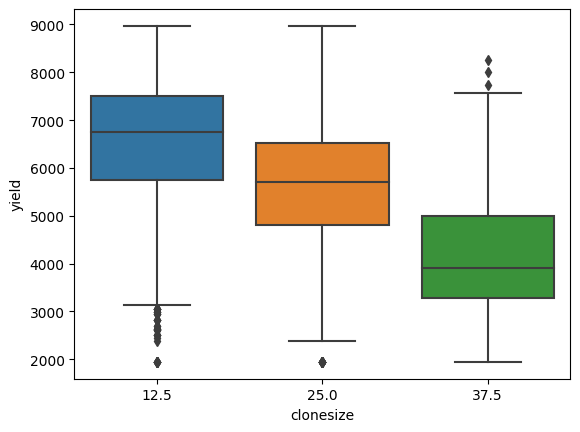

In [13]:
data['clonesize'] = np.where(data['clonesize'] == 40.0, 37.5, data['clonesize'])
data['clonesize'] = np.where(data['clonesize'] == 10.0, 12.5, data['clonesize'])
data['clonesize'] = np.where(data['clonesize'] == 20.0, 25.0, data['clonesize'])

test['clonesize'] = np.where(test['clonesize'] == 10.0, 12.5, test['clonesize'])
test['clonesize'] = np.where(test['clonesize'] == 20.0, 25.0, test['clonesize'])

#Plotting the graph again after changing the dataset
sns.boxplot(data = data, x = 'clonesize', y = 'yield');

<AxesSubplot: xlabel='honeybee', ylabel='yield'>

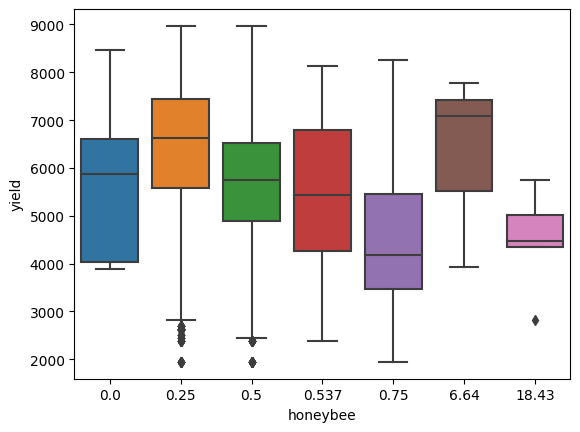

In [14]:
sns.boxplot(x='honeybee', y='yield', data=data)

<AxesSubplot: xlabel='honeybee', ylabel='yield'>

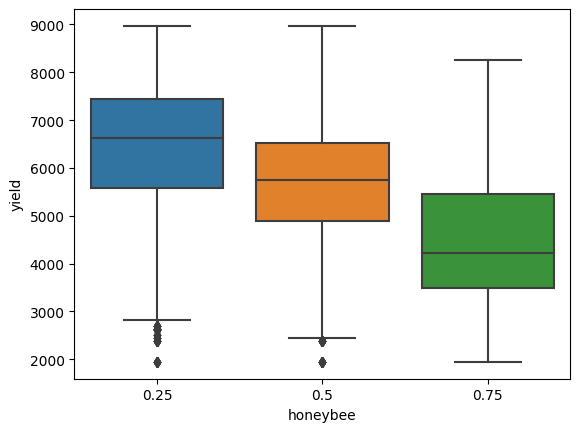

In [15]:
data['honeybee'] = np.where(data['honeybee'] == 0.000, 0.250, data['honeybee'])
data['honeybee'] = np.where(data['honeybee'] == 0.537, 0.500, data['honeybee'])
data['honeybee'] = np.where(data['honeybee'] == 6.640, 0.750, data['honeybee'])
data['honeybee'] = np.where(data['honeybee'] == 18.430, 0.750, data['honeybee'])

test['honeybee'] = np.where(test['honeybee'] == 0.000, 0.250, test['honeybee'])
test['honeybee'] = np.where(test['honeybee'] == 0.537, 0.500, test['honeybee'])
test['honeybee'] = np.where(test['honeybee'] == 6.640, 0.750, test['honeybee'])
test['honeybee'] = np.where(test['honeybee'] == 18.430, 0.750, test['honeybee'])

#Plotting the graph again after making changes to the datasets
sns.boxplot(x='honeybee', y='yield', data=data)

<AxesSubplot: xlabel='bumbles', ylabel='yield'>

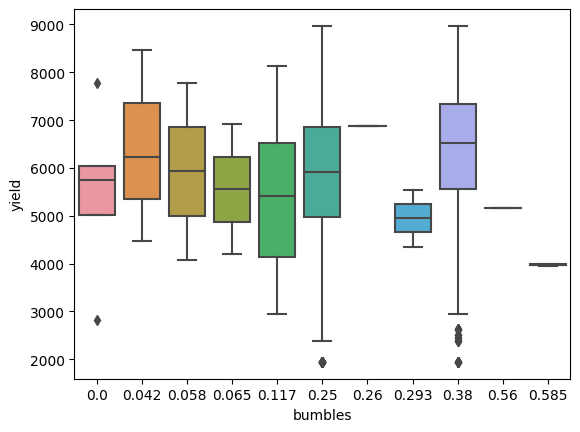

In [16]:
sns.boxplot(x='bumbles', y='yield', data=data)

<AxesSubplot: xlabel='bumbles', ylabel='yield'>

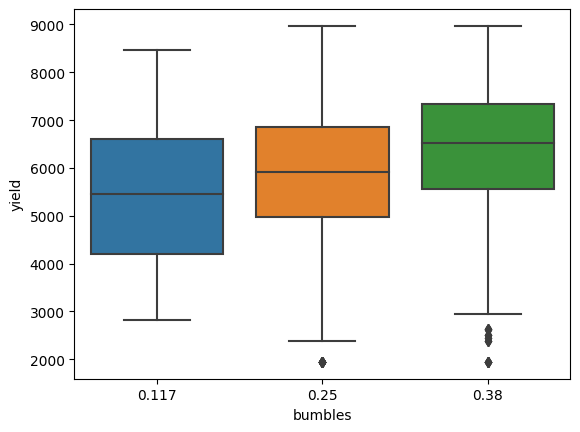

In [17]:
data['bumbles'] = np.where(data['bumbles'] == 0.000, 0.117, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.042, 0.117, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.058, 0.117, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.065, 0.117, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.585, 0.380, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.293, 0.250, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.560, 0.380, data['bumbles'])
data['bumbles'] = np.where(data['bumbles'] == 0.260, 0.250, data['bumbles'])

test['bumbles'] = np.where(test['bumbles'] == 0.000, 0.117, test['bumbles'])
test['bumbles'] = np.where(test['bumbles'] == 0.042, 0.117, test['bumbles'])
test['bumbles'] = np.where(test['bumbles'] == 0.058, 0.117, test['bumbles'])
test['bumbles'] = np.where(test['bumbles'] == 0.065, 0.117, test['bumbles'])
test['bumbles'] = np.where(test['bumbles'] == 0.585, 0.380, test['bumbles'])

# Plotting the graph again after making changes to the datasets
sns.boxplot(x='bumbles', y='yield', data=data)

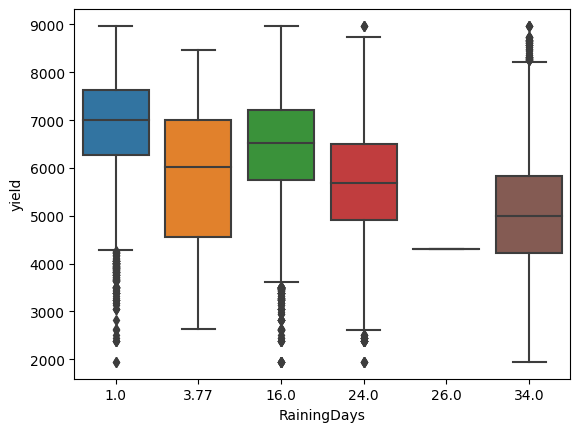

In [18]:
sns.boxplot(data = data, x = 'RainingDays', y = 'yield');

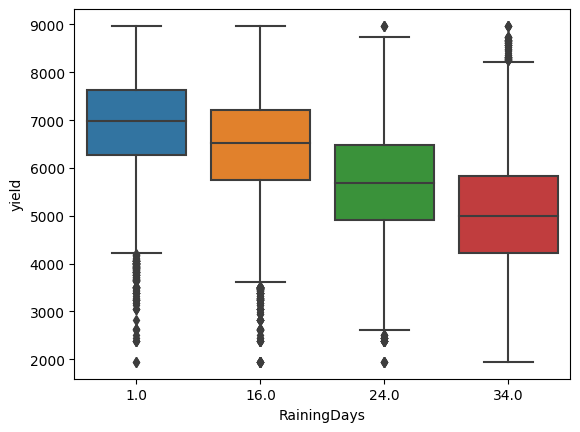

In [20]:
data['RainingDays'] = np.where(data['RainingDays'] == 3.77, 1.00, data['RainingDays'])
data['RainingDays'] = np.where(data['RainingDays'] == 26.00, 24.00, data['RainingDays'])

test['RainingDays'] = np.where(test['RainingDays'] == 3.77, 1.00, test['RainingDays'])
test['RainingDays'] = np.where(test['RainingDays'] == 33.00, 34.00, test['RainingDays'])

#Plotting the graph again after making changes to the dataset
sns.boxplot(data = data, x = 'RainingDays', y = 'yield');

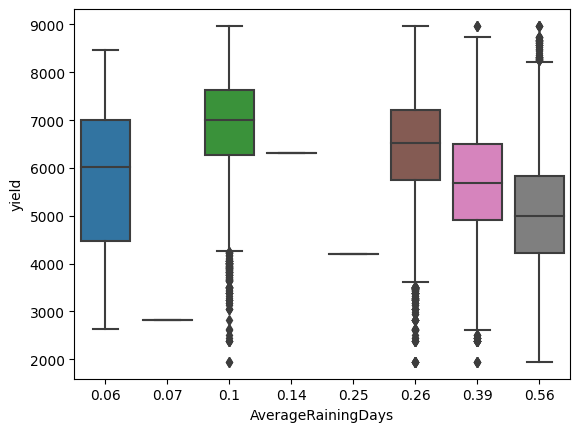

In [21]:
sns.boxplot(data = data, x = 'AverageRainingDays', y = 'yield');

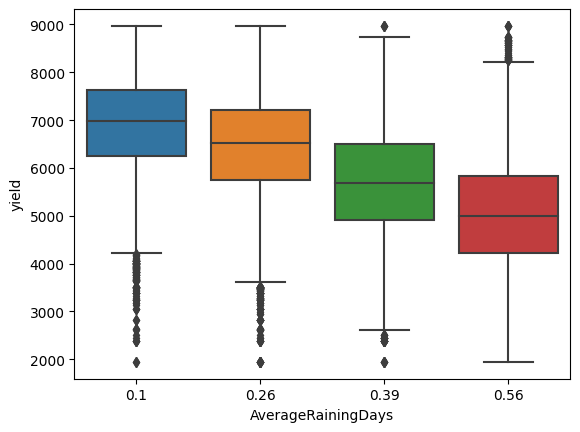

In [22]:
data['AverageRainingDays'] = np.where(np.isin(data['AverageRainingDays'], [0.06, 0.07, 0.14]), 0.10, data['AverageRainingDays'])
data['AverageRainingDays'] = np.where(data['AverageRainingDays'] == 0.25, 0.26, data['AverageRainingDays'])

test['AverageRainingDays'] = np.where(test['AverageRainingDays'] == 0.06, 0.10, test['RainingDays'])

#Plotting the graph after making changes to the dataset
sns.boxplot(data = data, x = 'AverageRainingDays', y = 'yield');

Temperature range
вместо того, чтобы использовать отдельно верхний и нижний диапазоны температур, мы могли бы создать новую функцию для дневного диапазона температур (верхний — нижний). Это может помочь отразить влияние колебаний температуры на опыление и урожайность.

Temperature extremes:
Экстремальные температуры: создайте бинарные функции, указывающие, превышает ли дневная температура определенные пороговые значения (например, экстремально высокие или низкие температуры). Эти функции могут помочь определить дни с потенциально опасными температурами, которые могут повлиять на опыление и урожайность.

Total bee density:
суммируйте плотности всех видов пчел (медоносная пчела, шмель, пчела Андрена, пчела Осмия), чтобы создать новую функцию для общей плотности пчел. Это может помочь отразить совокупное влияние всех видов пчел на опыление и урожайность.

Bee species dominance:
рассчитайте долю каждого вида пчел в поле, что может помочь определить относительную важность каждого вида пчел в опылении.

Rain intensity:
вместо того, чтобы просто подсчитывать дождливые дни, вы можете рассчитать среднесуточное количество осадков в период цветения. Это может обеспечить более точное представление о доступности воды в период цветения.


In [23]:
# 1. Temperature range
data['TemperatureRange'] = data['MaxOfUpperTRange'] - data['MinOfLowerTRange']

# 2. Temperature extremes
threshold_high = 71.9  
threshold_low = 50    

data['ExtremeHighTemp'] = (data['AverageOfUpperTRange'] > threshold_high).astype(int)
data['ExtremeLowTemp'] = (data['AverageOfLowerTRange'] < threshold_low).astype(int)

# 3. Total bee density
data['TotalBeeDensity'] = data['honeybee'] + data['bumbles'] + data['andrena'] + data['osmia']

# 4. Bee species dominance
total_density = data['honeybee'] + data['bumbles'] + data['andrena'] + data['osmia']
data['HoneybeeDominance'] = data['honeybee'] / total_density
data['BumblesBeeDominance'] = data['bumbles'] / total_density
data['AndrenaBeeDominance'] = data['andrena'] / total_density
data['OsmiaBeeDominance'] = data['osmia'] / total_density

# 5. Rain intensity
data['RainIntensity'] = data['AverageRainingDays'] / data['RainingDays']

# 6. Interaction features
data['BeeDensity_TemperatureInteraction'] = data['TotalBeeDensity'] * data['TemperatureRange']
data['BeeDensity_RainInteraction'] = data['TotalBeeDensity'] * data['RainIntensity']

data["fruit_seed"] = data["fruitset"] * data["seeds"]
data["AverageTRange"]=(data["AverageOfUpperTRange"]+data["AverageOfLowerTRange"])/2
data["temperature_range"] = data["MaxOfUpperTRange"] - data["MinOfUpperTRange"] + data["MaxOfLowerTRange"] - data["MinOfLowerTRange"]
data["rainfall_intensity"] = data["RainingDays"] * data["AverageRainingDays"]
data["fruit_quality"] = data["fruitset"] * data["fruitmass"]
data["seed_to_fruit_ratio"] = data["seeds"] / data["fruitmass"]
temperature_ranges = ["MaxOfUpperTRange", "MinOfUpperTRange", "AverageOfUpperTRange","MaxOfLowerTRange", "MinOfLowerTRange", "AverageOfLowerTRange"]
pca = PCA(n_components=1)
data[["pca_temperature"]] = pca.fit_transform(data[temperature_ranges])
data = data.drop(temperature_ranges, axis=1)

### Посмотрим корреляцию с новыми признаками

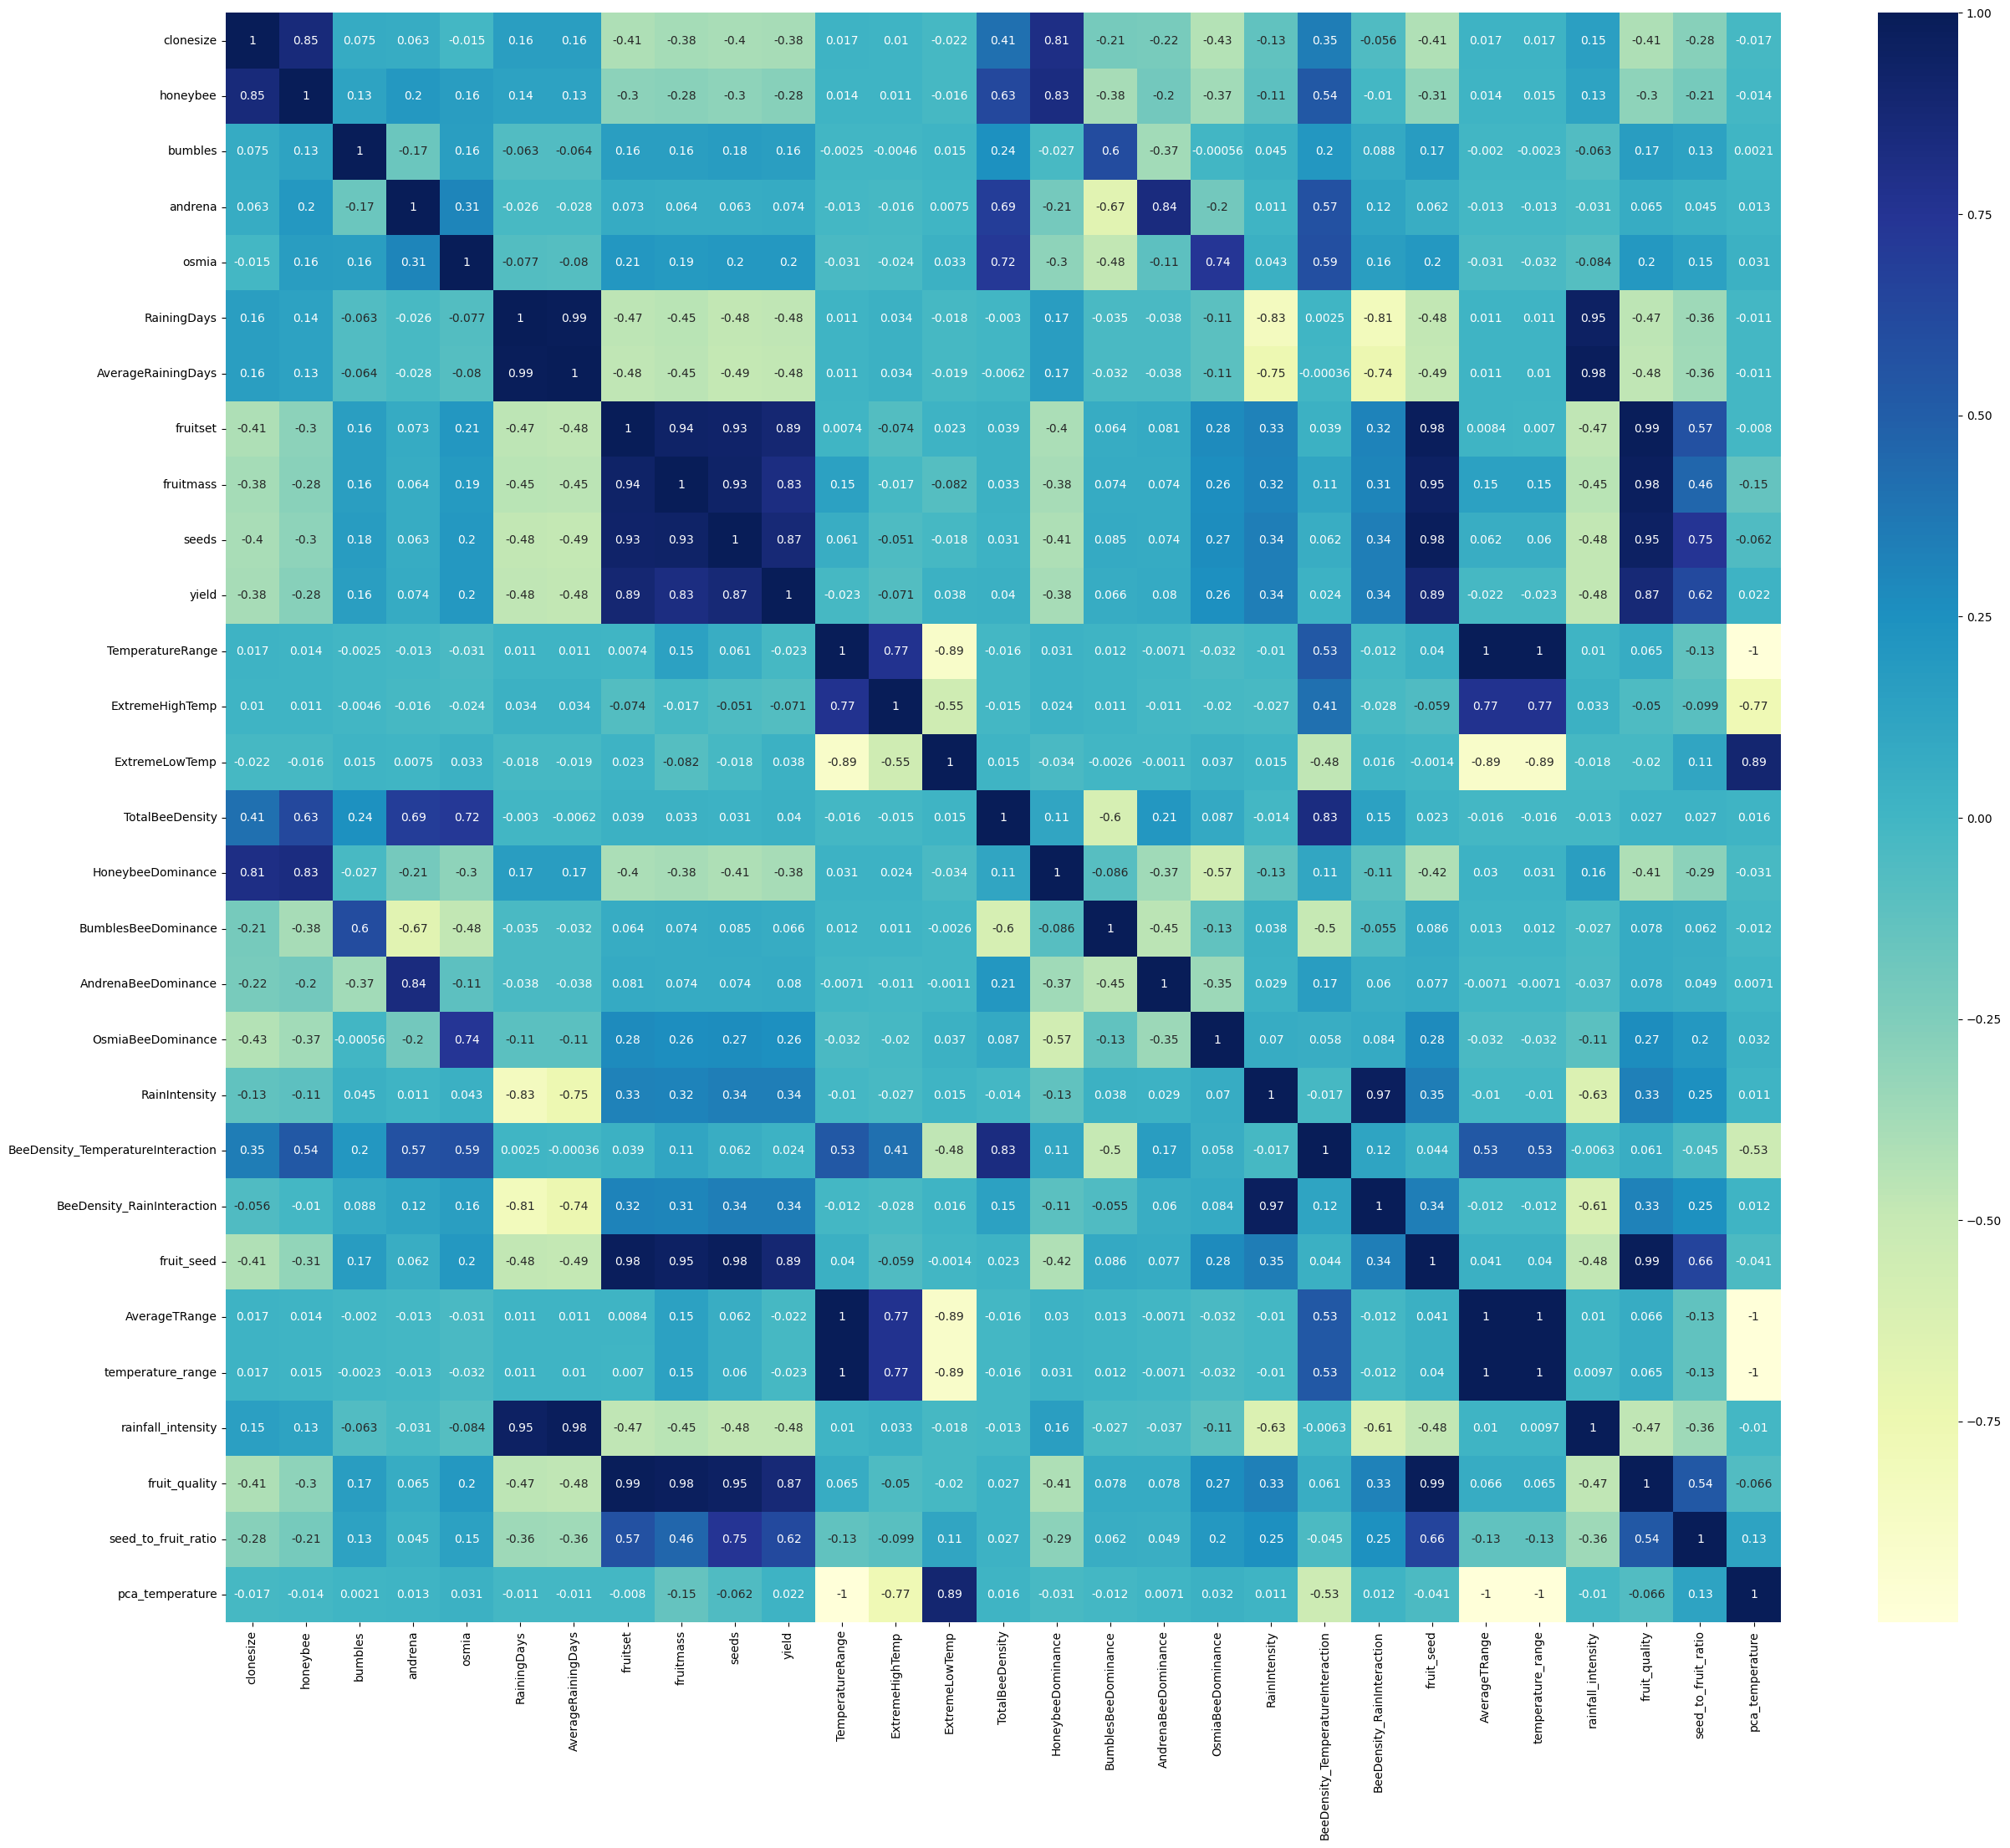

In [24]:
plt.figure(figsize = (30, 25))
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Preprocess the data

In [ ]:
# Выберем признаки, которые находятся в пределах от 0 до 100. Нормализем их.
RS = 13
scale_needed_features = ["clonesize", "RainingDays", "seeds", "TemperatureRange", "BeeDensity_TemperatureInteraction", "fruit_seed", "AverageTRange", "temperature_range","rainfall_intensity", "seed_to_fruit_ratio", "pca_temperature"]

In [25]:
X = data.drop('yield', axis=1)
y = data['yield']

seed = 42
splits = 5
k = KFold(n_splits = splits, random_state = seed, shuffle = True)

np.random.seed(seed)

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

### 0. Model Random Forest

In [36]:
def scaling(feature):
    global X_train, X_test
    scaler = MinMaxScaler()
    scaler.fit
    scaler.fit(X_train[feature].to_numpy().reshape(-1,1))
    X_train[feature] = scaler.transform(X_train[feature].to_numpy().reshape(-1,1))
    X_test[feature] = scaler.transform(X_test[feature].to_numpy().reshape(-1,1))

In [37]:
# Выберем признаки, которые находятся в пределах от 0 до 100. Нормализем их.
RS = 13
scale_needed_features = ["clonesize", "RainingDays", "seeds", "TemperatureRange", "BeeDensity_TemperatureInteraction", "fruit_seed", "AverageTRange", "temperature_range","rainfall_intensity", "seed_to_fruit_ratio", "pca_temperature"]

In [38]:
X = data.drop(["yield"], axis = 1)
y = data[["yield"]]
list_mae_rfr = []
for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = i)
    for feature in scale_needed_features:
        scaling(feature)
    rfr = RandomForestRegressor(random_state = RS)
    rfr.fit(X_train,y_train.values.ravel())
    rfr_prediction = rfr.predict(X_test)
    mae_rfr = mae(y_test,rfr_prediction)
    list_mae_rfr.append(mae_rfr)
print(f"Mean RFR 100-FOLD: {np.mean(list_mae_rfr)}")
print(f"Median RFR 100-FOLD: {np.median(list_mae_rfr)}")

Mean RFR 100-FOLD: 368.55794897795863
Median RFR 100-FOLD: 368.44644079429554


### 1. Base Model

In [39]:
def cross_val_score(model, cv = k, label = ''):
    
    X = train.copy()
    y = X.pop('yield')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(train)))
    train_predictions = np.zeros((len(train)))
    train_mae, val_mae = [], []
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model.fit(X.iloc[train_idx], y.iloc[train_idx])

        train_preds = model.predict(X.iloc[train_idx])
        val_preds = model.predict(X.iloc[val_idx])
                  
        train_predictions[train_idx] += train_preds
        val_predictions[val_idx] += val_preds
        
        train_score = mae(y.iloc[train_idx], train_preds)
        val_score = mae(y.iloc[val_idx], val_preds)
        
        train_mae.append(train_score)
        val_mae.append(val_score)
    
    print(f'Val MAE: {np.mean(val_mae):.5f} ± {np.std(val_mae):.5f} | Train MAE: {np.mean(train_mae):.5f} ± {np.std(train_mae):.5f} | {label}')
    
    return val_mae

In [40]:
mae_list = pd.DataFrame()

models = [
    ('linear', LinearRegression()),
    ('ridge', Ridge(random_state = seed)),
    ('lasso', Lasso(random_state = seed, max_iter = 1000000)),
    ('elastic', ElasticNet(random_state = seed, max_iter = 1000000)),
    ('huber', HuberRegressor(max_iter = 1000000)),
    ('ard', ARDRegression()),
    ('passive', PassiveAggressiveRegressor(random_state = seed)),
    ('theilsen', TheilSenRegressor(random_state = seed)),
    ('linearsvm', LinearSVR(random_state = seed, max_iter = 1000000)),
    ('mlp', MLPRegressor(random_state = seed, max_iter = 1000000)),
    ('et', ExtraTreesRegressor(random_state = seed)),
    ('rf', RandomForestRegressor(random_state = seed)),
    ('xgb', XGBRegressor(random_state = seed, eval_metric = 'mae')),
    ('lgb', LGBMRegressor(random_state = seed, objective = 'mae')),
    ('dart', LGBMRegressor(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostRegressor(random_state = seed, objective = 'MAE', verbose = 0)),
    ('gb', GradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('hgb', HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('knn', KNeighborsRegressor())
]

for (label, model) in models:
     mae_list[label] = cross_val_score(model, label = label)

Val MAE: 372.47437 ± 8.51416 | Train MAE: 370.86015 ± 1.95760 | linear
Val MAE: 374.94019 ± 8.40807 | Train MAE: 373.57471 ± 1.92031 | ridge
Val MAE: 379.87245 ± 7.39884 | Train MAE: 379.25182 ± 2.18366 | lasso
Val MAE: 433.49351 ± 6.04358 | Train MAE: 433.21688 ± 1.12319 | elastic
Val MAE: 369.70437 ± 13.03947 | Train MAE: 366.93871 ± 1.68387 | huber
Val MAE: 371.73262 ± 8.42432 | Train MAE: 371.46324 ± 1.89692 | ard
Val MAE: 539.35951 ± 116.05318 | Train MAE: 534.37737 ± 108.76084 | passive
Val MAE: 372.93603 ± 9.68529 | Train MAE: 372.30016 ± 2.84931 | theilsen
Val MAE: 457.18220 ± 5.11732 | Train MAE: 456.81314 ± 1.23151 | linearsvm
Val MAE: 452.42597 ± 5.95118 | Train MAE: 451.77138 ± 1.19992 | mlp
Val MAE: 379.18939 ± 10.35786 | Train MAE: 0.06745 ± 0.01088 | et
Val MAE: 367.08953 ± 9.41690 | Train MAE: 137.09607 ± 1.24347 | rf
Val MAE: 370.95395 ± 7.48493 | Train MAE: 250.01664 ± 1.92511 | xgb
Val MAE: 343.64786 ± 7.84157 | Train MAE: 318.08179 ± 2.13036 | lgb
Val MAE: 569.00047

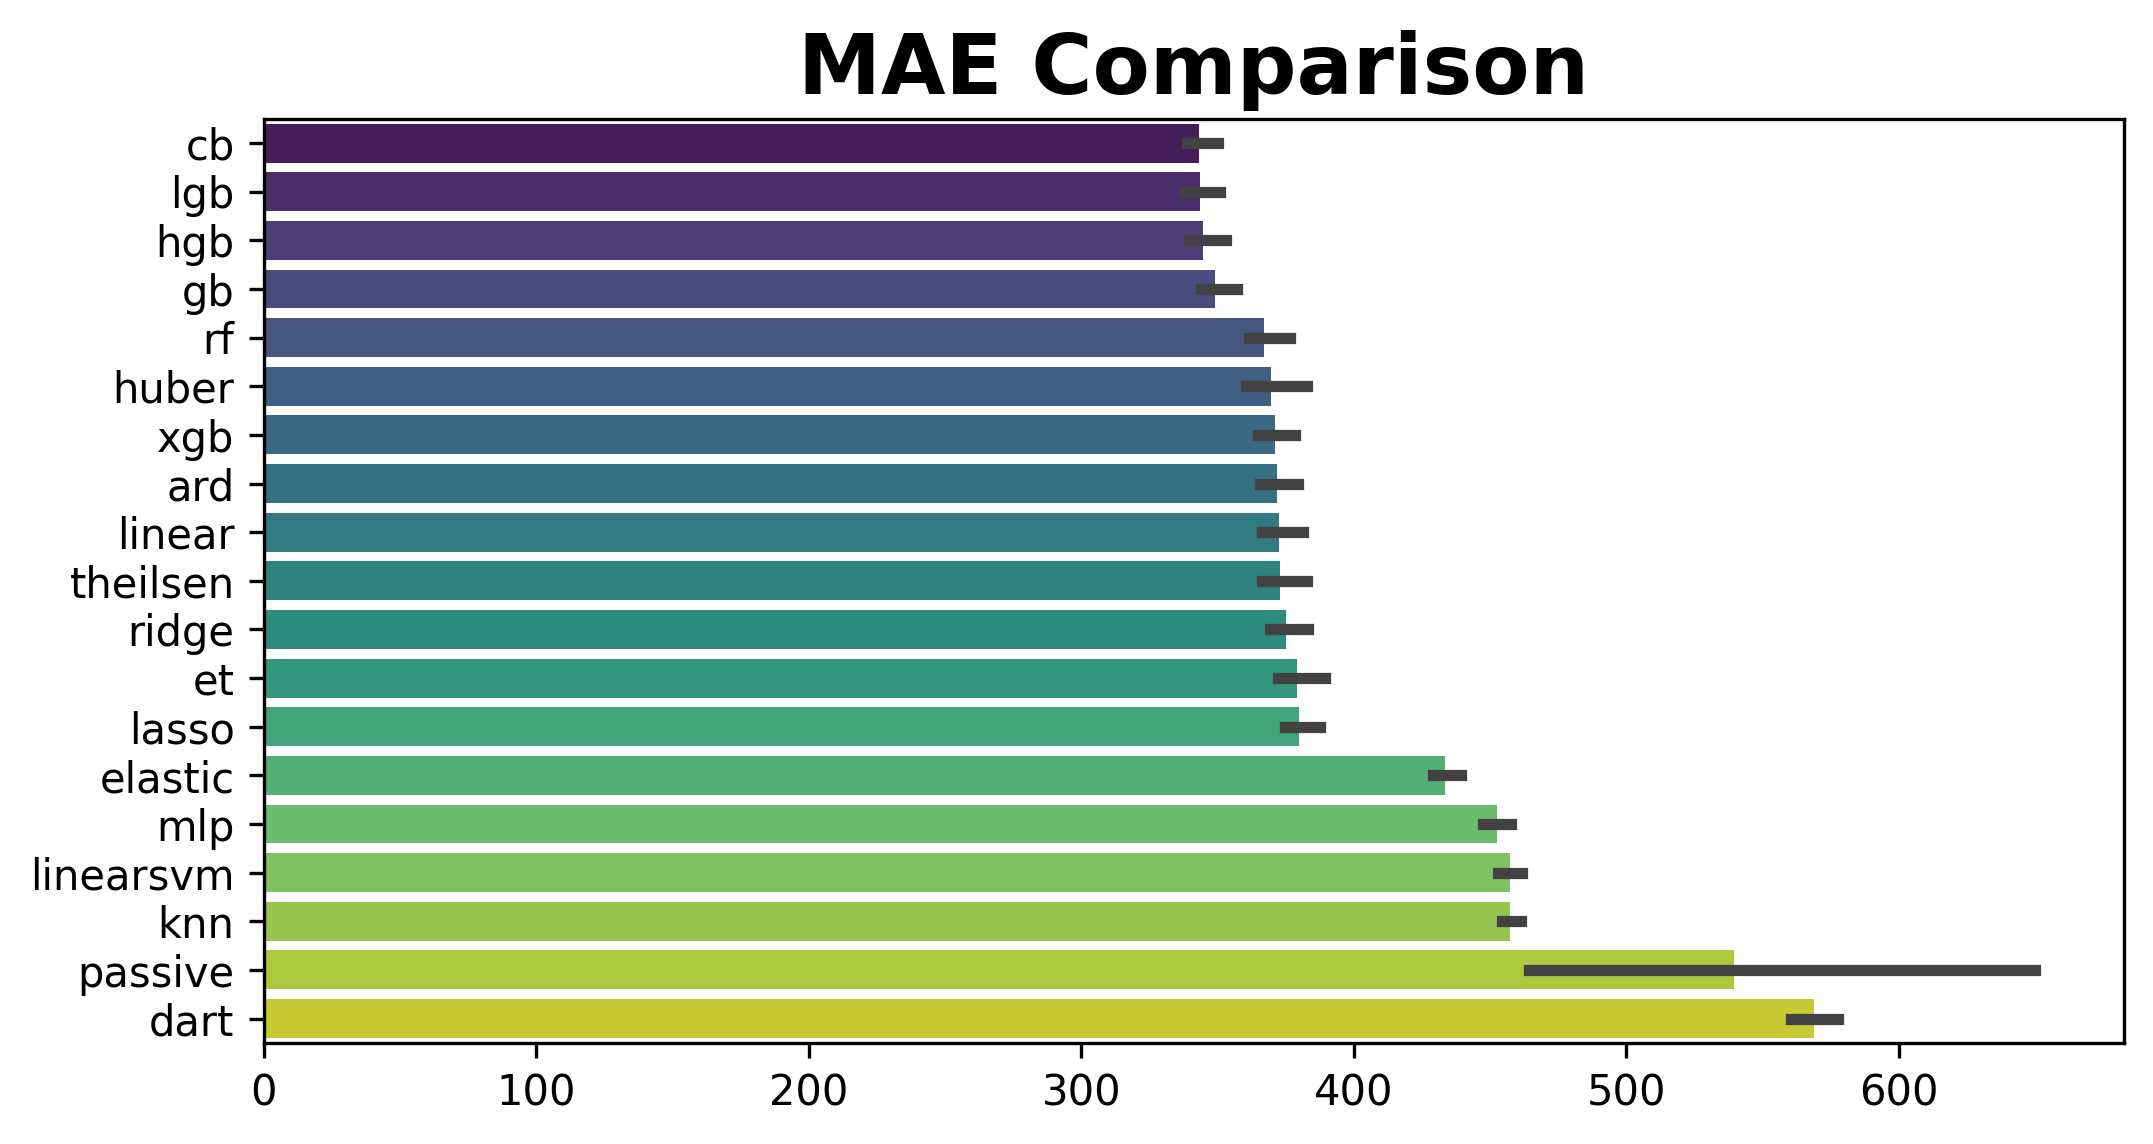

In [41]:
# Построим графики по моделям

plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = mae_list.reindex((mae_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('MAE Comparison', weight = 'bold', size = 20)
plt.show()

### 2. Попробуем подобрать Гиперпараметры Optuna и обучить несколько моделей

In [42]:
# Define Optuna objectives for each model
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 31, 127)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

def catboost_objective(trial):
    iterations = trial.suggest_int("iterations", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 9)
    subsample = trial.suggest_float("subsample", 0.5, 1)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [43]:
# Run Optuna optimization for each model
sampler = TPESampler(seed=42)

xgb_study = optuna.create_study(direction="maximize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=50)

lgbm_study = optuna.create_study(direction="maximize", sampler=sampler)
lgbm_study.optimize(lgbm_objective, n_trials=50)

catboost_study = optuna.create_study(direction="maximize", sampler=sampler)
catboost_study.optimize(catboost_objective, n_trials=50)

# Print best hyperparameters for each model from Optuna
print("Best parameters for XGBoost from Optuna: ", xgb_study.best_params)
print("Best parameters for LightGBM from Optuna: ", lgbm_study.best_params)
print("Best parameters for CatBoost from Optuna: ", catboost_study.best_params)

[I 2023-05-15 13:18:17,519] A new study created in memory with name: no-name-82d7a95b-3b5e-4c3f-8e20-5d3da09137aa
[I 2023-05-15 13:18:23,339] Trial 0 finished with value: 0.8048537482119511 and parameters: {'n_estimators': 250, 'learning_rate': 0.19063571821788408, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.8048537482119511.
[I 2023-05-15 13:18:28,385] Trial 1 finished with value: 0.7996898544045908 and parameters: {'n_estimators': 162, 'learning_rate': 0.021035886311957897, 'max_depth': 9, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 0.8048537482119511.
[I 2023-05-15 13:18:31,422] Trial 2 finished with value: 0.8031478811235989 and parameters: {'n_estimators': 108, 'learning_rate': 0.19428287191077892, 'max_depth': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 0.8048537482119511.
[I 2023-05-15 1

Best parameters for XGBoost from Optuna:  {'n_estimators': 401, 'learning_rate': 0.06050403812694402, 'max_depth': 4, 'subsample': 0.8187525294291716, 'colsample_bytree': 0.6042013897265752}
Best parameters for LightGBM from Optuna:  {'n_estimators': 141, 'learning_rate': 0.08385262025029953, 'max_depth': 4, 'num_leaves': 117, 'subsample': 0.7998034060530911, 'colsample_bytree': 0.5005261175858254}
Best parameters for CatBoost from Optuna:  {'iterations': 329, 'learning_rate': 0.04005807543833649, 'depth': 8, 'l2_leaf_reg': 2, 'subsample': 0.7968331478669399}


### Принять гиперпараметры

In [44]:
# Применим лучшие гиперпараметры GridSearchCV
xgb_best_params = {'n_estimators': 298, 'learning_rate': 0.02678212266181068, 'max_depth': 6, 'subsample': 0.6853208428200712, 'colsample_bytree': 0.542466436737164}
lgbm_best_params = {'n_estimators': 129, 'learning_rate': 0.07396328607001809, 'max_depth': 7, 'num_leaves': 42, 'subsample': 0.9459605953815196, 'colsample_bytree': 0.5138890153071075}
catboost_best_params = {'iterations': 439, 'learning_rate': 0.06091532313651278, 'depth': 6, 'l2_leaf_reg': 2, 'subsample': 0.5991381871815594}

# # Убучим несколько моделей с базовыми параметрами
xgb = XGBRegressor(**xgb_best_params, random_state=42)
lgbm = LGBMRegressor(**lgbm_best_params, random_state=42)
catboost = CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0)

In [45]:
# Выберем функцию с помощью SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
# Объединяем базовые модели, для ансамбля и назначения весов
weights = [0.4, 0.3, 0.3]
# Объединяем базовые модели для создания ансамбля
ensemble = VotingRegressor([('xgb', xgb), ('lgbm', lgbm), ('catboost', catboost)])
# Обучаем ансамбль, используя выбранные функции
ensemble.fit(X_train_selected, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.542466436737164,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,...
                                          monotone_constraints=None,
                                          n_estimators=298, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...)),
                            ('lgbm',
                             LGBMRegressor(colsample_bytree=0.5138890153071075,
                                           learning_rate=0.07396328607001809,
                                           max_depth=7, n_estimators=129,
                                           num_leaves=42, random_state=42,
                                           subsample=0.9459605953815196)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x78381a426a70>)])

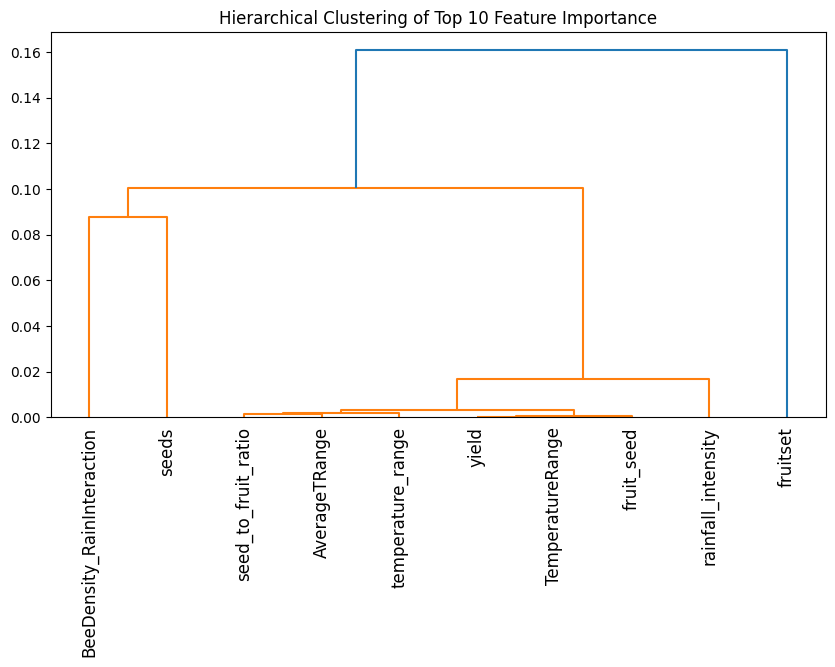

In [47]:
# Обучаем самую эффективную XGBoost model с лучшими hyperparameters от Optuna
best_xgb = XGBRegressor(**xgb_study.best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Получим значения важности функции
importances = best_xgb.feature_importances_

# Количество функций для визуализации
top_n = 10

# Отсортируем функции по важности и выберем лучшие N
sorted_idx = np.argsort(importances)[-top_n:]
top_features = data.columns[:-1][sorted_idx].tolist()

# Выполним иерархическую кластеризацию на top N функциях
linked = linkage(np.array(importances[sorted_idx]).reshape(-1, 1), 'single')

# Строим dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=top_features, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering of Top {} Feature Importance".format(top_n))
plt.xticks(rotation=90) 
plt.show()

### Cross Validation

In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kfold, scoring='r2')
print("Cross-validation scores: ", cv_scores)
print("Mean CV R-squared: {:.2f}".format(np.mean(cv_scores)))
print("Standard Deviation of CV R-squared: {:.2f}".format(np.std(cv_scores)))

TypeError: cross_val_score() got multiple values for argument 'cv'

In [ ]:
# Делаем прогнозы, используя выбранные функции
y_pred = ensemble.predict(X_test_selected)

# Оценка производительности
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared: {:.2f}".format(r2))

In [ ]:
# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

### Apply feature engineering on test data

In [ ]:
# 1. Temperature range
test['TemperatureRange'] = test['MaxOfUpperTRange'] - test['MinOfLowerTRange']

# 2. Temperature extremes
threshold_high = 71.9  
threshold_low = 50    

test['ExtremeHighTemp'] = (test['AverageOfUpperTRange'] > threshold_high).astype(int)
test['ExtremeLowTemp'] = (test['AverageOfLowerTRange'] < threshold_low).astype(int)

# 3. Total bee density
test['TotalBeeDensity'] = test['honeybee'] + test['bumbles'] +test['andrena'] + test['osmia']

# 4. Bee species dominance
total_density = test['honeybee'] + test['bumbles'] + test['andrena'] + test['osmia']
test['HoneybeeDominance'] = test['honeybee'] / total_density
test['BumblesBeeDominance'] = test['bumbles'] / total_density
test['AndrenaBeeDominance'] = test['andrena'] / total_density
test['OsmiaBeeDominance'] = test['osmia'] / total_density

# 5. Rain intensity
test['RainIntensity'] = test['AverageRainingDays'] / test['RainingDays']

# 6. Interaction features
test['BeeDensity_TemperatureInteraction'] = test['TotalBeeDensity'] * test['TemperatureRange']
test['BeeDensity_RainInteraction'] = test['TotalBeeDensity'] * test['RainIntensity']

test["fruit_seed"] = test["fruitset"] * test["seeds"]
test["AverageTRange"]=(test["AverageOfUpperTRange"]+test["AverageOfLowerTRange"])/2
test["temperature_range"] = test["MaxOfUpperTRange"] - test["MinOfUpperTRange"] + test["MaxOfLowerTRange"] - test["MinOfLowerTRange"]
test["rainfall_intensity"] = test["RainingDays"] * test["AverageRainingDays"]
test["fruit_quality"] = test["fruitset"] * test["fruitmass"]
test["seed_to_fruit_ratio"] = test["seeds"] / test["fruitmass"]
temperature_ranges = ["MaxOfUpperTRange", "MinOfUpperTRange", "AverageOfUpperTRange","MaxOfLowerTRange", "MinOfLowerTRange", "AverageOfLowerTRange"]
pca = PCA(n_components=1)
test[["pca_temperature"]] = pca.fit_transform(test[temperature_ranges])
test = test.drop(temperature_ranges, axis=1)

In [ ]:
# Scale
X_test_scaled = scaler.transform(test)

# Apply feature selection
X_test_selected = selector.transform(X_test_scaled)

# Make predictions
y_test_pred = ensemble.predict(X_test_selected)

In [ ]:
y_test_pred

### выгружаем для submit

In [ ]:
# Create a new DataFrame with ID column and predicted yields
result_df = pd.DataFrame({'id': test_df['id'], 'yield': y_test_pred})

# Save the DataFrame
result_df.to_csv('predictions.csv', index=False)

In [ ]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e14/sample_submission.csv')
sub.head()

In [ ]:
sub['yield'] = y_test_pred.reshape((-1))
#sub = test[['row_id','microbusiness_density']]
#sub.to_csv('submission.csv',index=False)
print(sub.shape)
sub.head()

In [ ]:
sub.to_csv('submission.csv',index=False)

### VotingRegressor

In [50]:
kf = KFold(n_splits=10, shuffle=True, random_state = 13)

In [51]:
train_mae, valid_mae = [], []
train_loss, valid_loss = [], []

In [52]:
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns.tolist())

In [53]:
y = y.reset_index(drop = True)

In [54]:
xgb_params = {
    'n_estimators': 585,
    'max_depth': 7,
    'learning_rate': 0.0116,
    'colsample_bytree': 1,
    'subsample': 0.6085,
    'min_child_weight': 9,
    'reg_lambda': 4.879e-07,
    'max_bin': 431,
    'n_jobs': -1,
    'eval_metric': 'mae',
    'objective': "reg:squarederror",
    'verbosity': 0,
    'random_state': 13,
        }

rf_params = {
    'n_estimators': 150,
    'max_depth': 9,
    'max_features': 'auto',
    'min_samples_split': 4,
    'min_samples_leaf': 4  
        }

lgbm_params = {
    'n_estimators': 2550,#250
    'num_leaves': 57,
    'max_depth': 8, 
    'min_child_samples': 9,
    'learning_rate': 0.04,
    'colsample_bytree': 0.8,#0.87
    'reg_alpha': 0.001,
    'reg_lambda': 0.002,
    'subsample': 0.7,
    'objective': 'regression_l1',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'max_bin': 1000,
    'n_jobs': -1,
    'bagging_freq': 1, 
    'random_state': 42
}

cb_params = {
    'n_estimators': 350,
    'depth': 15,
    'learning_rate': 0.09,
    'random_strength': 0.2,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bayesian',
    'eval_metric': 'MAE',
    'loss_function': 'MAE',
    'random_state': 42,
    'silent': True
}

models = [
    ('lgb', lgb.LGBMRegressor(**lgbm_params)),
    ('cb', cb.CatBoostRegressor(**cb_params))
]

In [55]:
for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    print(f"Fold {i}:")
    X_train = X_scaled.loc[train_index]
    y_train = y.loc[train_index]

    X_valid = X_scaled.loc[valid_index]
    y_valid = y.loc[valid_index]
    
#     lgb_model = lgb.LGBMRegressor(**lgb_params)
#     rf_model = RandomForestRegressor(**rf_params)
#     cb_model = cb.CatBoostRegressor(**cb_params)
#     xgb_model = xgb.XGBRegressor(**xgb_params)
    
    voter = VotingRegressor(models)

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_valid, label=y_valid)
    
#     model = lgb.train(lgb_params, train_data, valid_sets=[train_data, val_data], early_stopping_rounds=200, verbose_eval=False)
    
    voter.fit(X_train, y_train)
              
    train_pred = voter.predict(X_train)
    valid_pred = voter.predict(X_valid)
    
    train_mae_score = mae(y_train.to_numpy(), train_pred)
    valid_mae_score = mae(y_valid.to_numpy(), valid_pred)
              
    train_mae.append(train_mae_score)
    valid_mae.append(valid_mae_score)
              
    print(f'Valid MAE Score: {np.mean(train_mae):.5f} ± {np.std(train_mae):.5f} | Train MAE Score: {np.mean(valid_mae):.5f} ± {np.std(valid_mae):.5f}')
    print('')
print(f"Average MAE Score: {(np.mean(valid_mae + np.std(valid_mae))):.5f}")

Fold 0:


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 262.47124 ± 0.00000 | Train MAE Score: 332.65624 ± 0.00000

Fold 1:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 261.49980 ± 0.97145 | Train MAE Score: 341.19786 ± 8.54162

Fold 2:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 260.74483 ± 1.33007 | Train MAE Score: 345.93452 ± 9.67013

Fold 3:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 260.16851 ± 1.52422 | Train MAE Score: 350.51783 ± 11.53923

Fold 4:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 260.37084 ± 1.42209 | Train MAE Score: 348.82486 ± 10.86221

Fold 5:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 260.89180 ± 1.74421 | Train MAE Score: 344.51789 ± 13.82291

Fold 6:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 261.42715 ± 2.08022 | Train MAE Score: 340.48341 ± 16.16907

Fold 7:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 261.58986 ± 1.99291 | Train MAE Score: 339.56038 ± 15.32067

Fold 8:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 261.42053 ± 1.93902 | Train MAE Score: 341.10478 ± 15.09053

Fold 9:
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid MAE Score: 261.39548 ± 1.84105 | Train MAE Score: 341.76165 ± 14.45112

Average MAE Score: 356.21277


In [ ]:
test = test.drop(['id'], axis = 1)

In [57]:
scaled_test = scaler.transform(test)

In [ ]:
y_test_pred = voter.predict(scaled_test)

In [ ]:
submit['yield'] = y_test_pred

In [ ]:
submit.to_csv('submission.csv', index = False)

### Построим CNN

In [ ]:
# Выберем признаки, которые находятся в пределах от 0 до 100. Нормализем их.
scale_features = ["clonesize", "RainingDays", "seeds", "TemperatureRange", "BeeDensity_TemperatureInteraction", "fruit_seed", "AverageTRange", "temperature_range","rainfall_intensity", "seed_to_fruit_ratio", "pca_temperature"]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[scale_features])
data[scale_features] = scaler.transform(data[scale_features])

In [ ]:
X = data.drop('yield', axis=1)
y = data['yield']

In [ ]:
input_cols = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'RainingDays',
       'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'TemperatureRange', 'ExtremeHighTemp', 'ExtremeLowTemp',
       'TotalBeeDensity', 'HoneybeeDominance', 'BumblesBeeDominance',
       'AndrenaBeeDominance', 'OsmiaBeeDominance', 'RainIntensity',
       'BeeDensity_TemperatureInteraction', 'BeeDensity_RainInteraction',
       'fruit_seed', 'AverageTRange', 'temperature_range',
       'rainfall_intensity', 'fruit_quality', 'seed_to_fruit_ratio',
       'pca_temperature']
target_cols = ['yield']

In [ ]:
input_cols = list(train.columns)[:-1]
target_col = list(train.columns)[-1]
input_cols, target_col

In [ ]:
X_data = X.values.reshape(15282,2,2,7)
targets = y.values.reshape(-1,1)

In [ ]:
X = data.drop('yield', axis=1)
y = data['yield']

In [ ]:
# Convert the data from numpy array to tensor
inputs = X_data.astype("float32")
targets = targets.astype("float32")
inputs = torch.from_numpy(np.array(inputs))
targets = torch.from_numpy(np.asarray(targets))

In [ ]:
dataset = TensorDataset(inputs, targets)

In [ ]:
dataset[0:2]

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

### Создаем наборы данных для обучения и проверки
Для оценки производительности модели всегда необходимо проверять производительность модели, и для этого набор данных должен быть отделен от фактических обучающих данных.

In [ ]:
val_size = 1000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

### Создание пакетов данных
Мы также можем разделить данные на количество пакетов при выполнении модели обучения, и это ускорит процессы обучения.

In [ ]:
batch_size = 75
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

### Создать класс модели
Мы можем расширить библиотеку nn.Module для настройки нашего шаблона модели в соответствии с нашими требованиями. Ниже мы создали отдельные объекты для обучения, проверки и распечатки потерь.

In [ ]:
class blueberrybase(nn.Module):
    def training_step(self, batch):
        in_fts, targets = batch
        out = self(in_fts)
        loss = loss_fn(out, targets)
        return loss
    
    def validation_step(self, batch):
        in_fts, targets = batch
        out = self(in_fts)
        loss = loss_fn(out, targets)
        return {"val_loss":loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {"val_loss":epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss:{:.4f}".format(epoch, result["val_loss"]))

В классе ниже мы расширяем библиотеку до условного нейронного метода.

In [ ]:
class blueberryconvmodel(blueberrybase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=2, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 28, kernel_size=2, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(28,32,kernel_size=2,padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(), 
            nn.Linear(32*2*1, 28),
            nn.ReLU(),
            nn.Linear(28, 8),
            nn.ReLU(),
            nn.Linear(8, 1))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = blueberryconvmodel()
model

### Создайте объект для оценки производительности модели и распечатайте потери

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
loss_fn = F.l1_loss

In [ ]:
model.share_memory

In [ ]:
evaluate(model, val_dl)

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam

lr=.05
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
lr=.005
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
lr=.0005
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
lr=.00005
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    val_loss = [x['val_loss'] for x in history]
    train_loss = [x["train_loss"] for x in history]
    plt.plot(val_loss, '-x')
    plt.plot(train_loss, "-o")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_accuracies(history)

Обработка Test

In [ ]:
test = test.set_index("id")
test.head()

In [ ]:
test[scale_features] = scaler.transform(test[scale_features])

In [ ]:
test_tensor = torch.from_numpy(test.values.reshape(10194,2,2,7).astype("float32"))

In [ ]:
test_result = model(test_tensor)
test_result

In [ ]:
test_result = test_result.detach().numpy()

In [ ]:
submit["yield"]=test_result
submit.head()

In [ ]:
submit.to_csv("sample_submission.csv", index=False)